# Прогнозирование успешности стартапа
**Цель работы:** предсказать закроется тот или иной стартап.  

**Задачи**:
1. Подготовить данные: заполнить пропуски, ввести новые категории, по возможности убрать аномальные значения.
2. Составить pipeline и подобрать наилучшую модель.
3. Получить предсказание модели на тестовой выборке.

**План работы:**
1. Загрузить данные.
2. Оценить количество пропусков и по возможности устранить их.
3. Оценить количество дубликатов и по возможности устранить их.
4. Оценить распределение данных и по возможности устранить аномальные значения.
5. Ввести новые признаки на основе имеющихся.
6. Составить матрицу корреляции признаков.
7. Составить pipeline с несколькими моделями.
8. Подобрать в pipeline оптимальную модель и рассчитать её качество.
9. Получить предсказание лучшей модели на тестовых значениях.

**Описание данных:**  

Данные представлены тремя файлами:
- тренировочный набор kaggle_startups_train_01.csv. В наборе около 53 000 записей. Набор используется для обучения. Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'.
- тестовый набор kaggle_startups_test_01.csv. В наборе около 13 000 записей. Набор используется для проверки качества модели. Для набора необходимо предсказать статус стартапа - закроется или нет.
- файл с примерами предсказаний kaggle_startups_sample_submit_01.csv.
Столбцы в файлах:
- name - идентификатор (название) стартапа.
- status - целевой признак. Для каждого стартапа необходимо указать категориальное значение ['operating', 'closed'].
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

## Загрузка библиотек

Сперва установим и загрузим необходимые библиотеки:

In [ ]:
!pip install phik
!pip install shap

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     GridSearchCV)

from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

import shap

# Обработка ошибок
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/startups-operations-close-predictions-m1-35-ds/kaggle_startups_train_28062024.csv
/kaggle/input/startups-operations-close-predictions-m1-35-ds/kaggle_startups_sample_submit_28062024.csv
/kaggle/input/startups-operations-close-predictions-m1-35-ds/kaggle_startups_test_28062024.csv


#### Функции

Сформируем нужные функции.

In [ ]:
# Функция для обзора данных
def data_review(list_df):
    for i in list_df:
        print(f'Общая информация в датафрейме:\n')
        print(f'{i.info()}\n\n Первые пять строк датафрейма:\n\n {i.head()}\n')

In [ ]:
# Функции кодирования признаков
def manufact_cat(df):
    if ('manufact' in str(df).lower()) | ('indust' in str(df).lower()) | ('automo' in str(df).lower()) | ('semicondu' in str(df).lower()):
        return 1

def bio_cat(df):
    if ('bio' in str(df).lower()) | ('agric' in str(df).lower()) | ('veter' in str(df).lower()):
        return 1

def medic_cat(df):
    if ('medic' in str(df).lower()) | ('healt' in str(df).lower()) | ('fitne' in str(df).lower()) | ('care' in str(df).lower()) | ('pharmaceut' in str(df).lower()) | ('babi' in str(df).lower()) | ('beau' in str(df).lower()) | ('wellne' in str(df).lower()) | ('sport' in str(df).lower()):
        return 1

def it_cat(df):
    if ('softw' in str(df).lower()) | ('hardw' in str(df).lower()) | ('mobil' in str(df).lower()) | ('web' in str(df).lower()) | ('apps' in str(df).lower()) | ('game' in str(df).lower()) | ('intern' in str(df).lower()) | ('3d' in str(df).lower()) | ('data' in str(df).lower()) | ('analyt' in str(df).lower()) | ('cyber' in str(df).lower()) | ('securi' in str(df).lower()):
        return 1

def fin_cat(df):
    if ('commerc' in str(df).lower()) | ('financ' in str(df).lower()) | ('advertis' in str(df).lower()) | ('estat' in str(df).lower()) | ('consult' in str(df).lower()) | ('bank' in str(df).lower()) | ('payme' in str(df).lower()) | ('market' in str(df).lower()) | ('manage' in str(df).lower()) | ('busine' in str(df).lower()):
        return 1

def hum_cat(df):
    if ('socia' in str(df).lower()) | ('languag' in str(df).lower()) | ('educat' in str(df).lower()) | ('home' in str(df).lower()) | ('crowdsour' in str(df).lower()) | ('recruit' in str(df).lower()) | ('resour' in str(df).lower()):
        return 1

def other_cat(df):
    if df['manufacturing'] + df['biotech'] + df['medicine'] + df['it'] + df['finance'] + df['human'] == 0:
        return 1

def cod_status(df):
    if df['status'] == 'operating':
        return 1

def word_status(df):
    if df['status_code'] == 1:
        return 'operating'
    else:
        return 'closed'


In [ ]:
def date_type(df, column): # Функция изменения типа на дату
    type_column = pd.to_datetime(df[column], format='%Y-%m-%d')
    return type_column

Функции для построения графиков

In [ ]:
def lunge_analysis(df, columns):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.

    Возвращает:
        Оформленные боксплоты и гистограммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax_1 = sns.histplot(data=df, x=column, bins=100, ax=ax[0])
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        plt.show()

In [ ]:
def hist_analysis(df, columns):
    """
    Функция строит гистограммы по переданному списку столбцов.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.

    Возвращает:
        Оформленные гистограммы.

    """
    for column in columns:
        ax = sns.histplot(data=df, x=column, bins=20)
        ax.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        plt.show()

## Знакомство с данными

Теперь познакомимся с данными.

In [ ]:
data_train = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m1-35-ds/kaggle_startups_train_28062024.csv')
data_test = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m1-35-ds/kaggle_startups_test_28062024.csv')
data_sample_submit = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m1-35-ds/kaggle_startups_sample_submit_28062024.csv')

In [ ]:
data_review([data_train, data_test, data_sample_submit])

Общая информация в датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None

 Первые пять строк датафрейма:

                      name            

Данные загружены. В первых двух датасетах имеются пропуски. Кроме того, в стоблцах с датами неправильный формат данных. Сперва заполним пропуски в таблице с данным для обучения.

In [ ]:
data_train['category_list'] = data_train['category_list'].fillna(data_train['name']) # заполним именем, так как возможно получиться установить категорию по имени компании.
data_train['name'] = data_train['name'].fillna('Not specified') # нет возможности однозначно установить название компании, если оно не указано.
data_train['country_code'] = data_train['country_code'].fillna('Not specified') # нет возможности однозначно установить страну компании.
data_train['state_code'] = data_train['state_code'].fillna('Not specified') # нет возможности однозначно установить страну компании.
data_train['region'] = data_train['region'].fillna('Not specified') # нет возможности однозначно установить страну компании.
data_train['city'] = data_train['city'].fillna('Not specified') # нет возможности однозначно установить страну компании.
data_train['funding_total_usd']= data_train['funding_total_usd'].fillna(data_train['funding_total_usd'].median()) # заполним медианным значением как наиболее вероятным из возможных вариантов.
data_train['closed_at']= data_train['closed_at'].fillna('2018-01-01') # дата выгрузки базы

Сделаем тоже самое с таблицей data_test

In [ ]:
data_test['category_list'] = data_test['category_list'].fillna(data_test['name'])
data_test['name'] = data_test['name'].fillna('Not specified')
data_test['country_code'] = data_test['country_code'].fillna('Not specified')
data_test['state_code'] = data_test['state_code'].fillna('Not specified')
data_test['region'] = data_test['region'].fillna('Not specified')
data_test['city'] = data_test['city'].fillna('Not specified')
data_test['funding_total_usd']= data_test['funding_total_usd'].fillna(data_test['funding_total_usd'].median())

Пропуски заполнены. Теперь изменим форматы данных.

In [ ]:
for column in ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']:
    data_train[column] = date_type(data_train, column)
for column in ['first_funding_at', 'last_funding_at']:
    data_test[column] = date_type(data_test, column)

Типы данных изменены. Проверим, всё ли изменилось.

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  52516 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          52516 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


В обоих таблицах все данные изменены, пропусков больше нет. Теперь проверим дубликаты в таблицах.

In [ ]:
data_train.duplicated().sum()

0

In [ ]:
data_train['name'].duplicated().sum()

0

In [ ]:
data_test.duplicated().sum()

0

In [ ]:
data_test['name'].duplicated().sum()

0

Полных дубликатов нет, дубликатов компаний нет. В других столбцах информация может быть не уникальной, поэтому проверка на дубликаты не требуется.

## Создание новых признаков

В целях лучшего понимания данных и улучшения качества модели создадим новые признаки.

Сперва посчитааем, сколько дней открыты каждая компания. В таблице data_test этот показатель уже есть, поэтому рассчитаем только для data_train.

In [ ]:
data_train['lifetime'] = (data_train['closed_at'] - data_train['founded_at']).dt.days

Теперь посчитаем, сколько времени прошло у каждой компании до первого финансирования.

In [ ]:
data_train['days_to_first_fund'] = (data_train['first_funding_at'] - data_train['founded_at']).dt.days

В таблице data_test нет начальной даты, но её можно получить. Сперва введем в таблицу дату выгрузки, потом вычтем из даты выгрузки количество дней жизни компании и получим дату основания стартапа.

In [ ]:
data_test['current_time'] = '2018-01-01'
data_test['current_time'] = date_type(data_test, 'current_time')

In [ ]:
data_test['founded_at'] = data_test['current_time'] - pd.to_timedelta(data_test['lifetime'], unit='d')

Теперь рассчитаем время до первого финансирования.

In [ ]:
data_test['days_to_first_fund'] = (data_test['first_funding_at'] - data_test['founded_at']).dt.days

Время получено. Теперь рассчитаем время между первым и последним финансированием.

In [ ]:
data_train['days_first_last_fund'] = (data_train['last_funding_at'] - data_train['first_funding_at']).dt.days
data_test['days_first_last_fund'] = (data_test['last_funding_at'] - data_test['first_funding_at']).dt.days

Теперь рассчитаем среднее время между раундами финансирования.

In [ ]:
data_train['avg_days_rounds'] = data_train['lifetime'] / data_train['funding_rounds']
data_test['avg_days_rounds'] = data_test['lifetime'] / data_test['funding_rounds']

Всё рассчитано. Теперь попробуем обработать столбец с категориями. Категорий очень много. Попробуем выделить 5 основных и расставить принадлежность компаний к этим категориям. Заодно закодируем целевой показатель.

In [ ]:
data_train['manufacturing'] = data_train['category_list'].apply(manufact_cat).fillna(0)
data_train['biotech'] = data_train['category_list'].apply(bio_cat).fillna(0)
data_train['medicine'] = data_train['category_list'].apply(medic_cat).fillna(0)
data_train['it'] = data_train['category_list'].apply(it_cat).fillna(0)
data_train['finance'] = data_train['category_list'].apply(fin_cat).fillna(0)
data_train['human'] = data_train['category_list'].apply(hum_cat).fillna(0)
data_train['other'] = data_train.apply(other_cat, axis=1).fillna(0)
data_train['cod_status'] = data_train.apply(cod_status, axis=1).fillna(0)

Теперь закодируем признаки в проверочной таблице.

In [ ]:
data_test['manufacturing'] = data_test['category_list'].apply(manufact_cat).fillna(0)
data_test['biotech'] = data_test['category_list'].apply(bio_cat).fillna(0)
data_test['medicine'] = data_test['category_list'].apply(medic_cat).fillna(0)
data_test['it'] = data_test['category_list'].apply(it_cat).fillna(0)
data_test['finance'] = data_test['category_list'].apply(fin_cat).fillna(0)
data_test['human'] = data_test['category_list'].apply(hum_cat).fillna(0)
data_test['other'] = data_test.apply(other_cat, axis=1).fillna(0)

Проверим, как создались новые признаки.

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  52516 non-null  object        
 1   category_list         52516 non-null  object        
 2   funding_total_usd     52516 non-null  float64       
 3   status                52516 non-null  object        
 4   country_code          52516 non-null  object        
 5   state_code            52516 non-null  object        
 6   region                52516 non-null  object        
 7   city                  52516 non-null  object        
 8   funding_rounds        52516 non-null  int64         
 9   founded_at            52516 non-null  datetime64[ns]
 10  first_funding_at      52516 non-null  datetime64[ns]
 11  last_funding_at       52516 non-null  datetime64[ns]
 12  closed_at             52516 non-null  datetime64[ns]
 13  lifetime        

In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  13125 non-null  object        
 1   category_list         13125 non-null  object        
 2   funding_total_usd     13125 non-null  float64       
 3   country_code          13125 non-null  object        
 4   state_code            13125 non-null  object        
 5   region                13125 non-null  object        
 6   city                  13125 non-null  object        
 7   funding_rounds        13125 non-null  int64         
 8   first_funding_at      13125 non-null  datetime64[ns]
 9   last_funding_at       13125 non-null  datetime64[ns]
 10  lifetime              13125 non-null  int64         
 11  current_time          13125 non-null  datetime64[ns]
 12  founded_at            13125 non-null  datetime64[ns]
 13  days_to_first_fu

Если вычесть два целевых столбца из тренеровочной выборке, то количество столбцов и их название совпадает в обоих таблицах.

### Анализ данных

Теперь построим гистограммы и боксплоты. Сначала начнем с числовых столбцов.

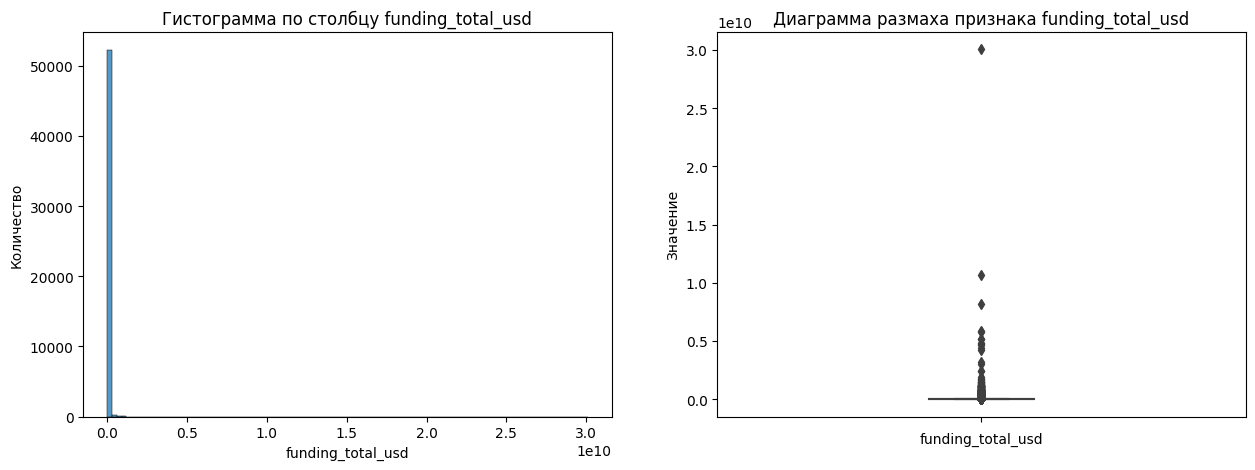

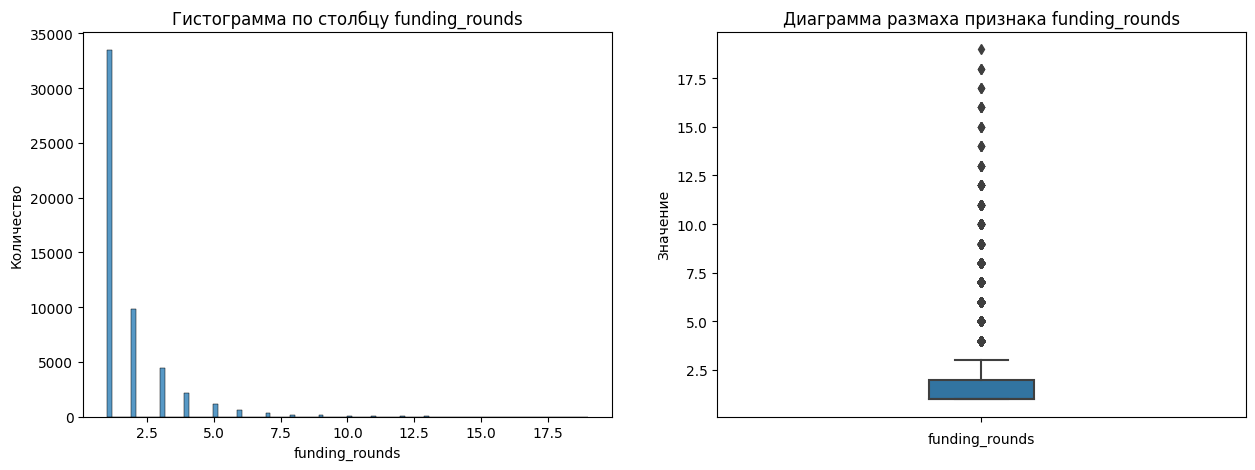

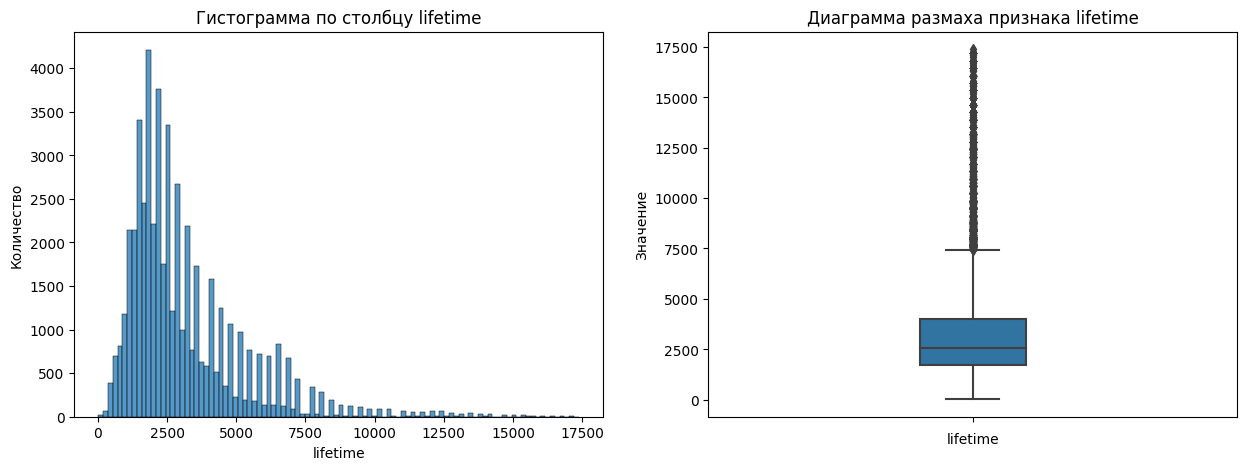

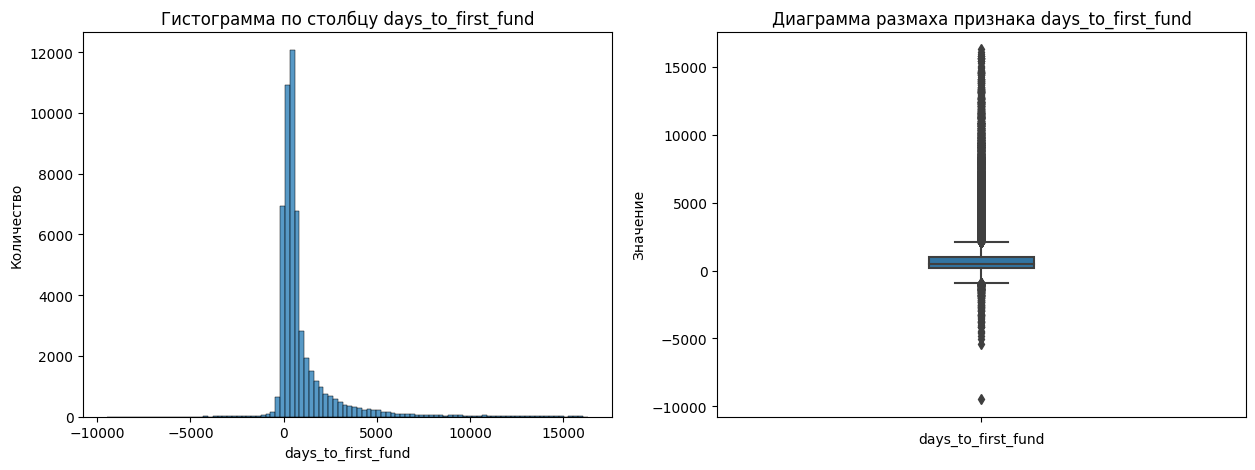

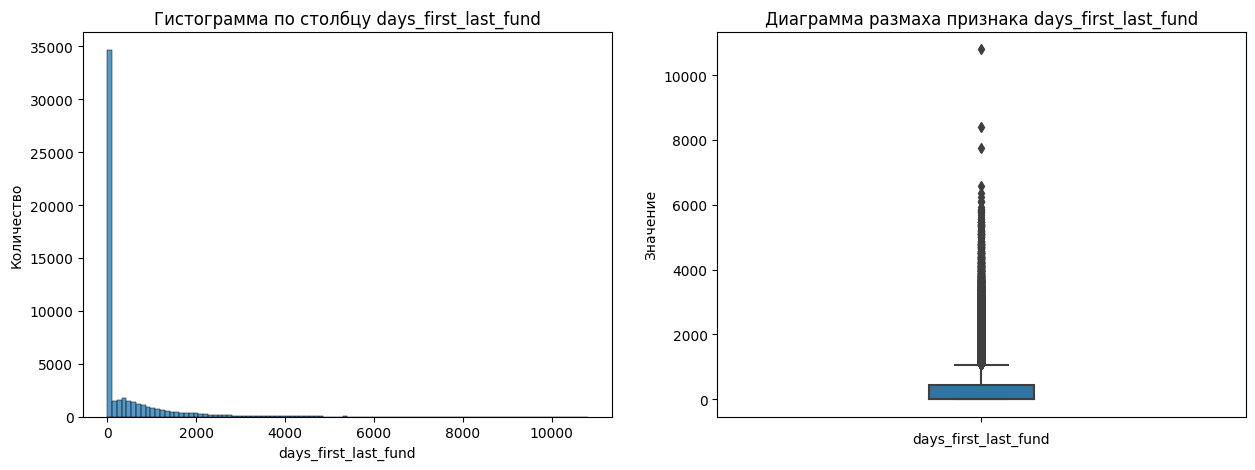

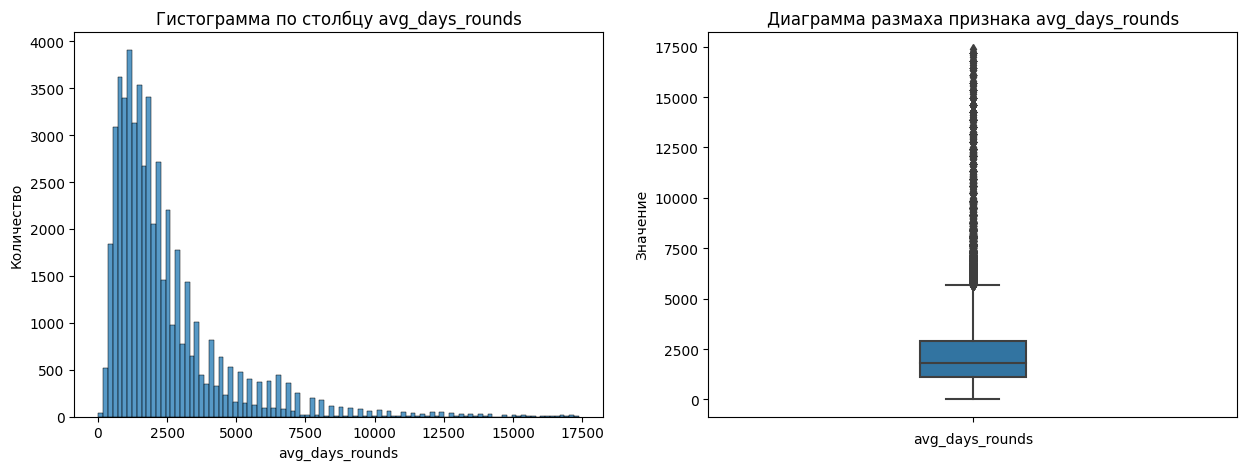

In [ ]:
lunge_analysis(data_train, ['funding_total_usd',
                            'funding_rounds',
                            'lifetime',
                            'days_to_first_fund',
                            'days_first_last_fund',
                            'avg_days_rounds'])

По гистораммам видно, что данные распределены не нормальным образом, в данных есть выбросы. Кроме того необычно поведение показателя lifetime. Компании четко делятся на две группы. посмотрим на те же столбцы в таблице для проверки.

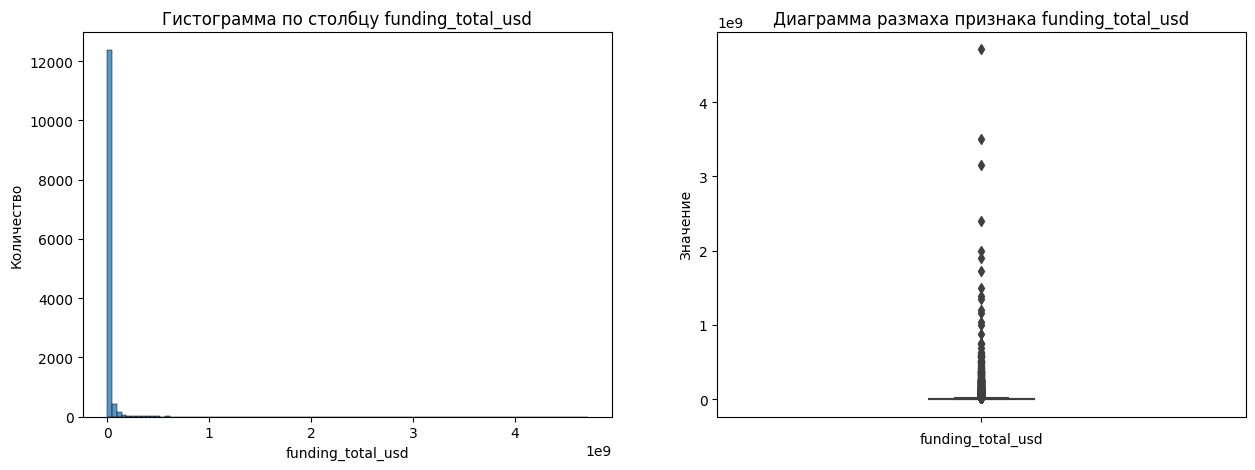

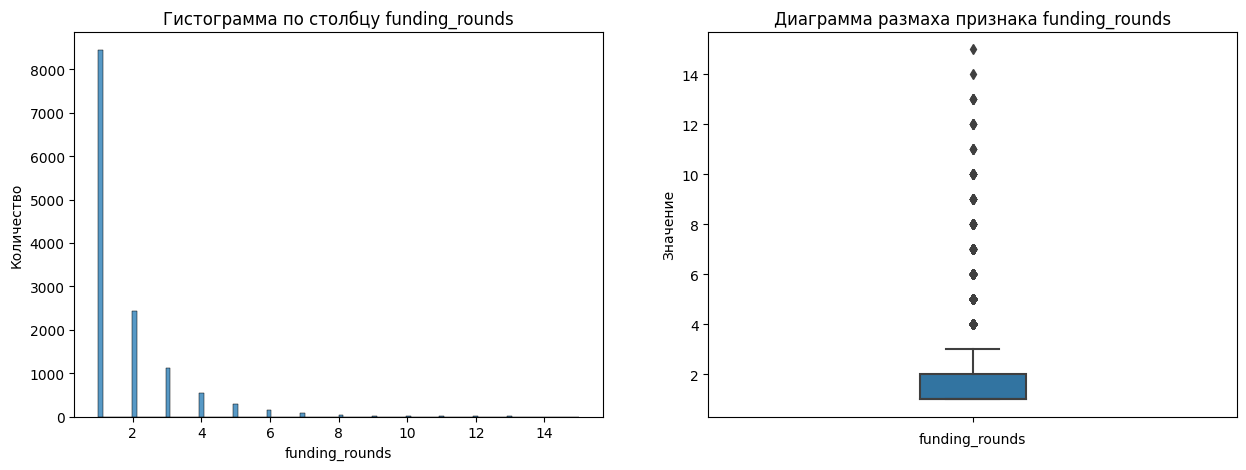

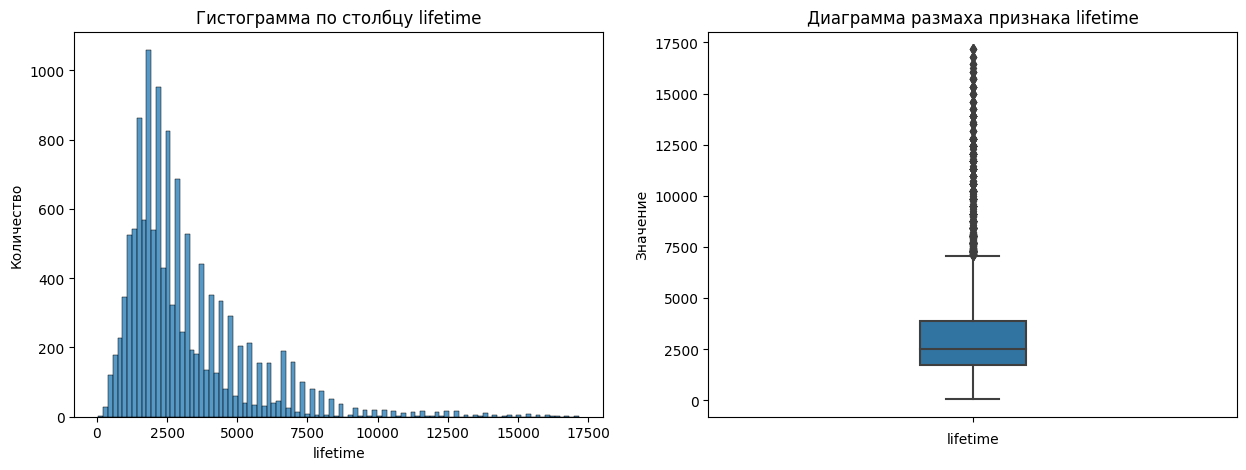

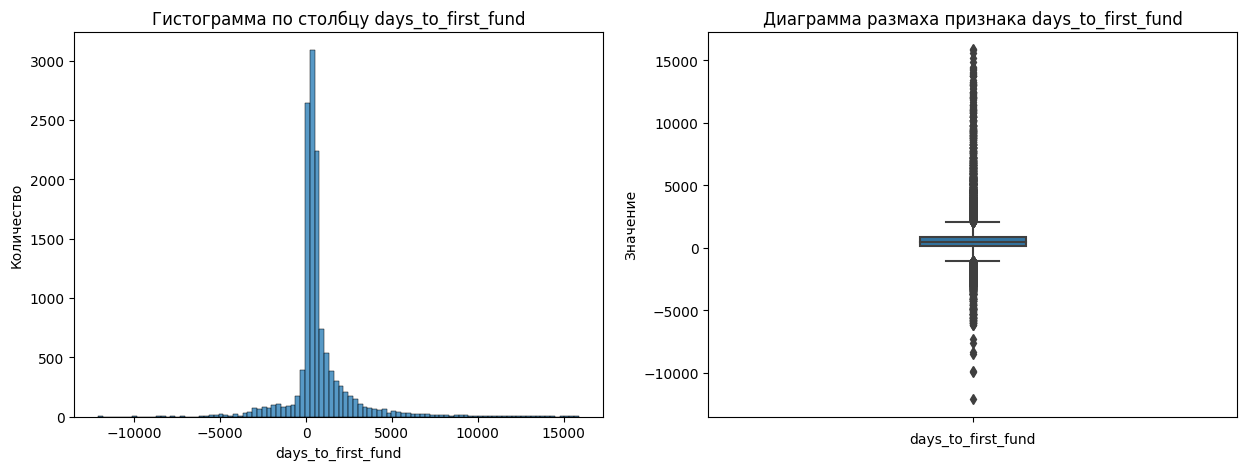

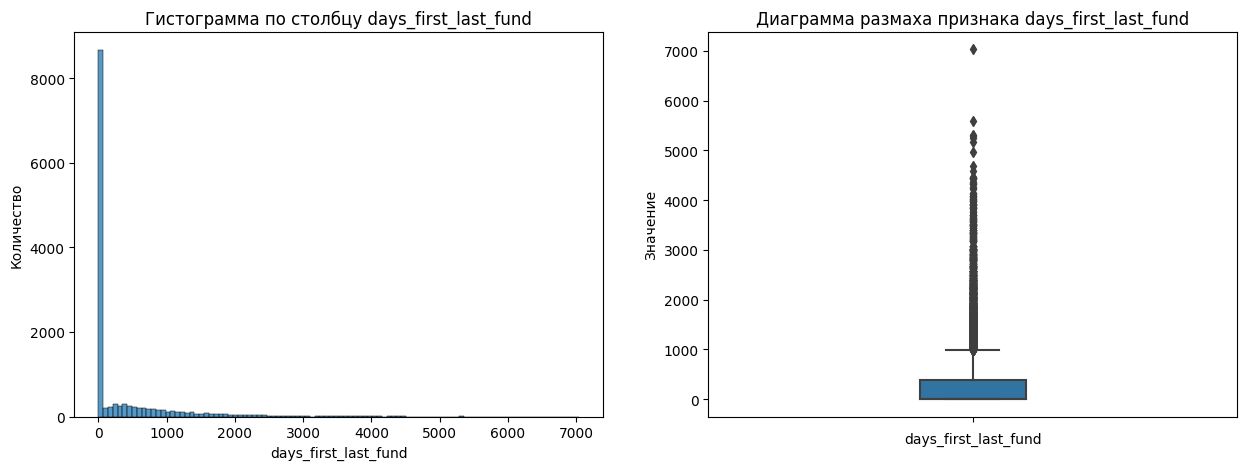

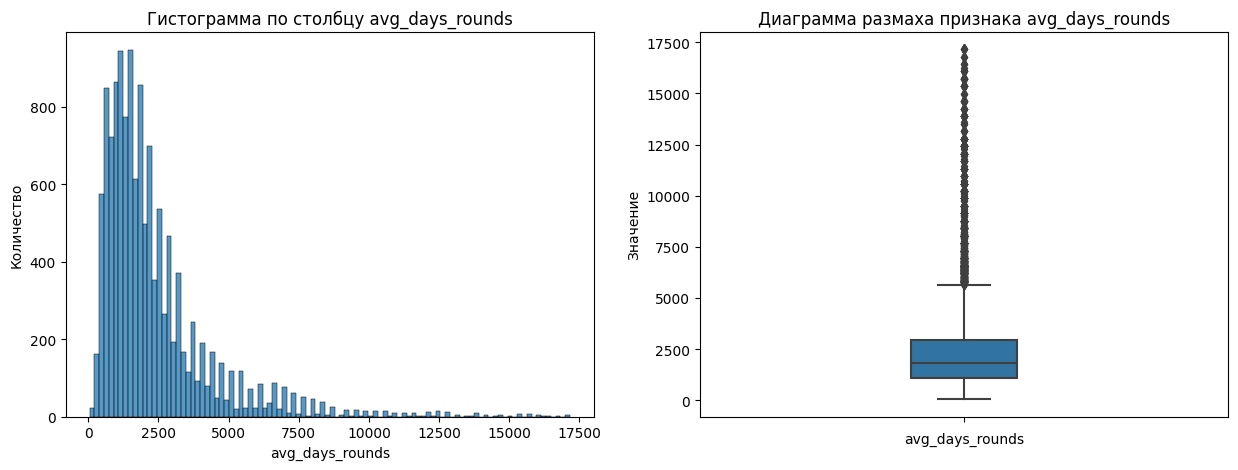

In [ ]:
lunge_analysis(data_test, ['funding_total_usd',
                            'funding_rounds',
                            'lifetime',
                            'days_to_first_fund',
                            'days_first_last_fund',
                            'avg_days_rounds'])

Выпады тоже есть, средние значения в ряде столбцов отличаются. Видно, что характер признака lifetime такой же.

Теперь проведем анализ других столбцов с нечисловыми значениями.

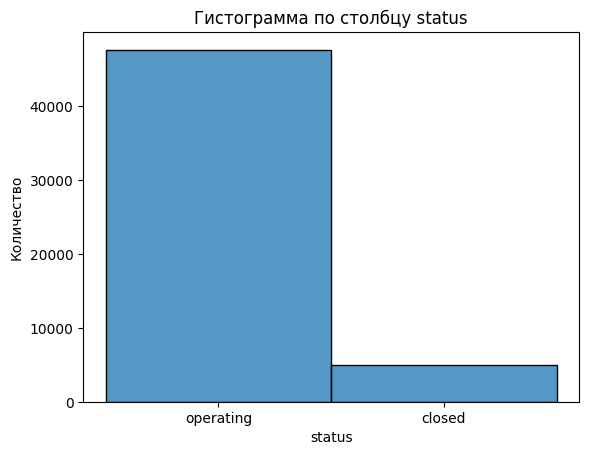

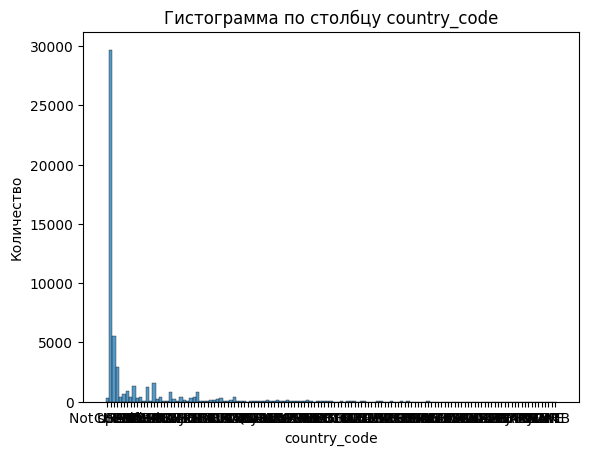

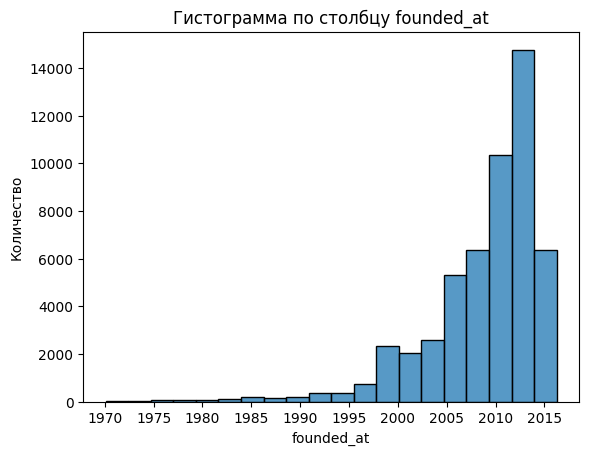

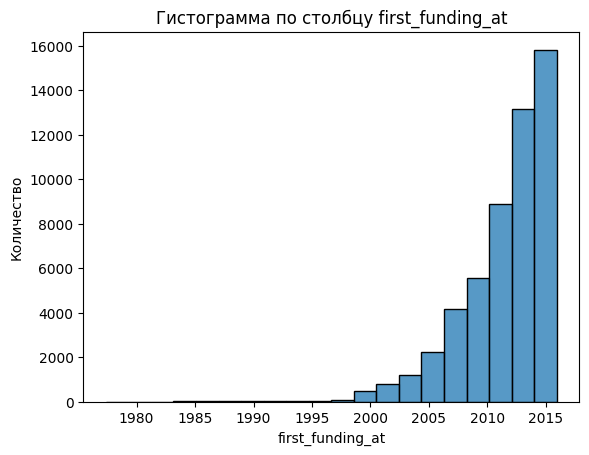

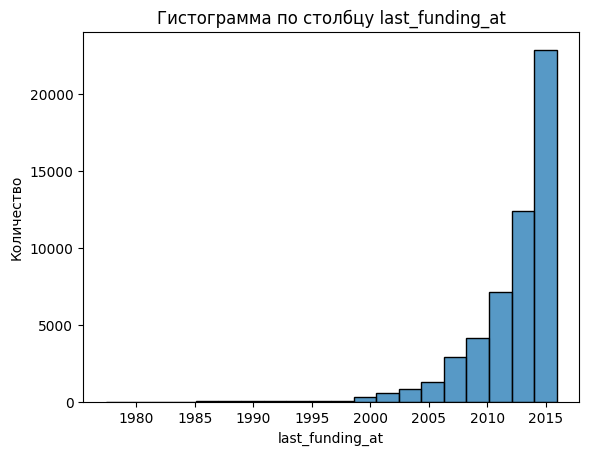

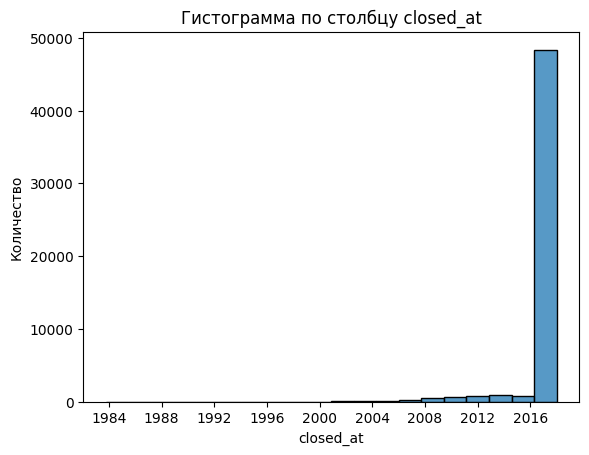

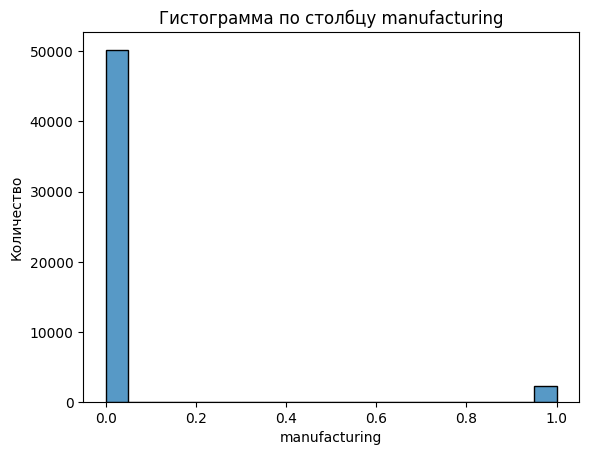

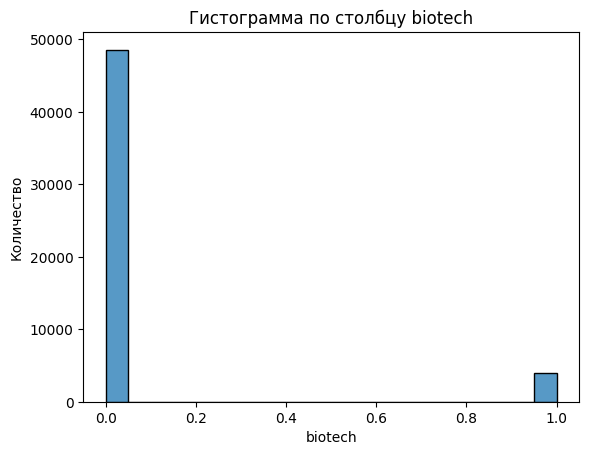

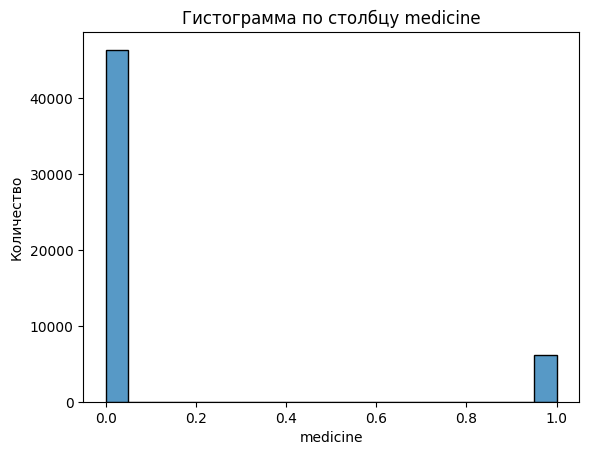

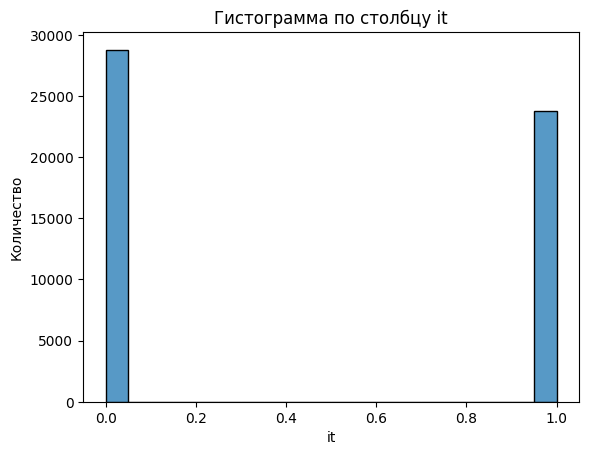

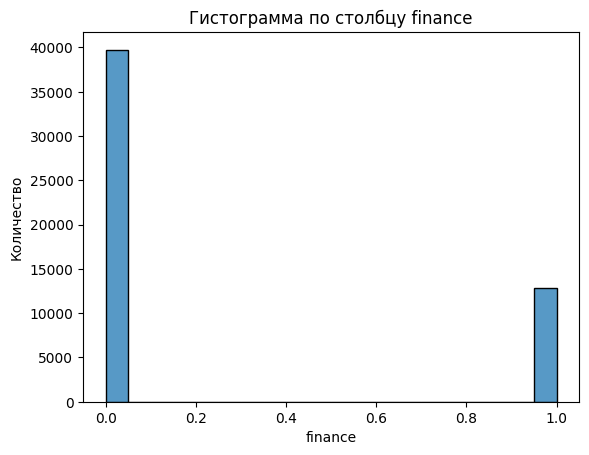

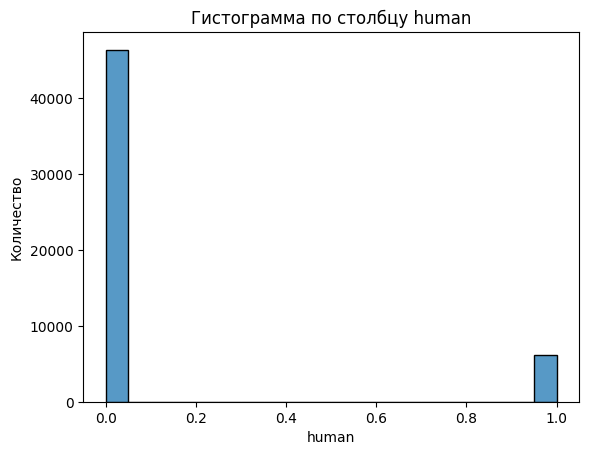

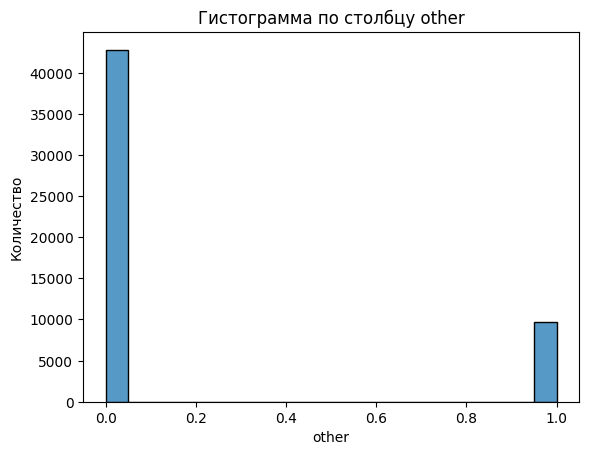

In [ ]:
hist_analysis(data_train, ['status',
                           'country_code',
                           'founded_at',
                           'first_funding_at',
                           'last_funding_at',
                           'closed_at',
                           'manufacturing',
                           'biotech',
                           'medicine',
                           'it',
                           'finance',
                           'human',
                           'other'])

Распределение опять далеко от нормально, однако видно, что кодирование категорий в целом успешное, так как большинство компаний были отнесены к какой-либо категории, кроме other.
Посмотрим на даты в таблице data_test.

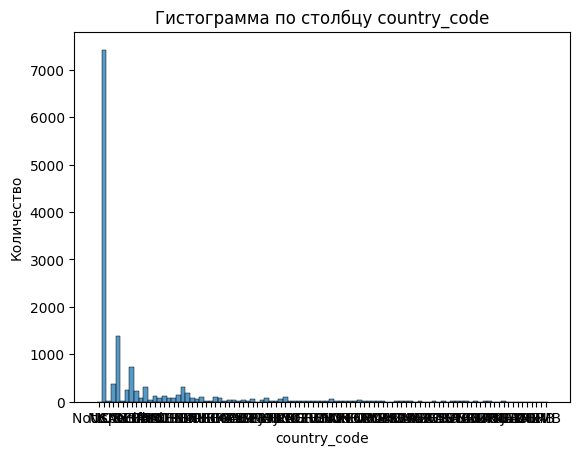

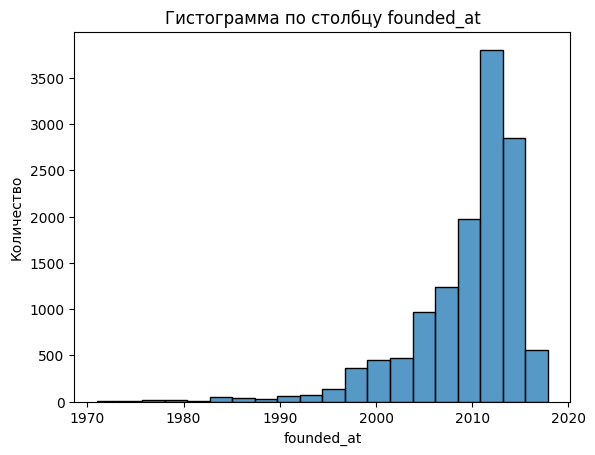

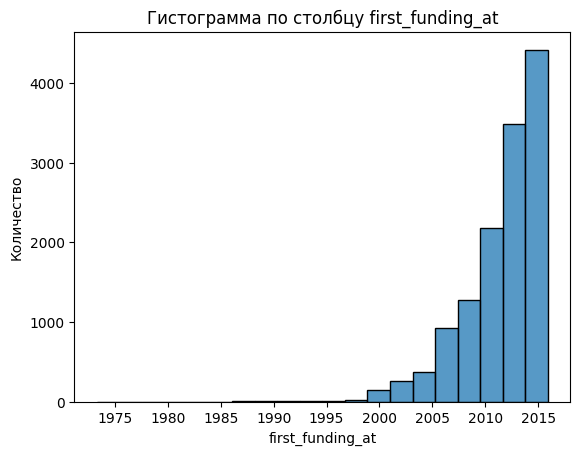

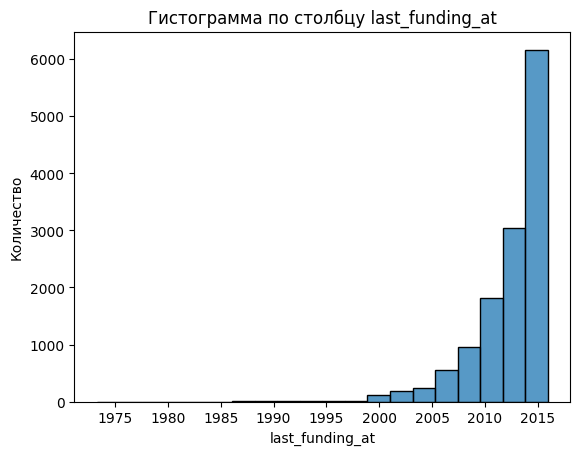

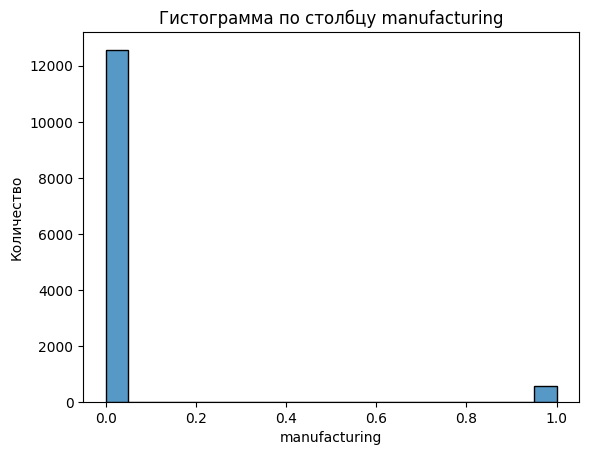

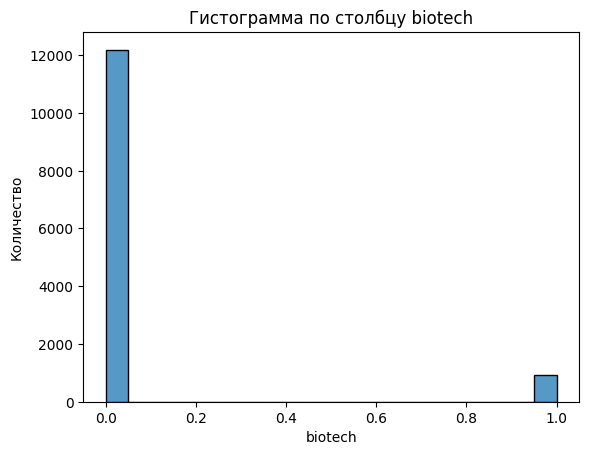

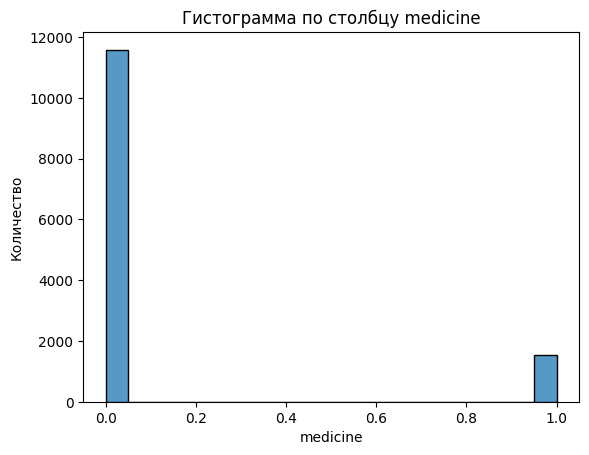

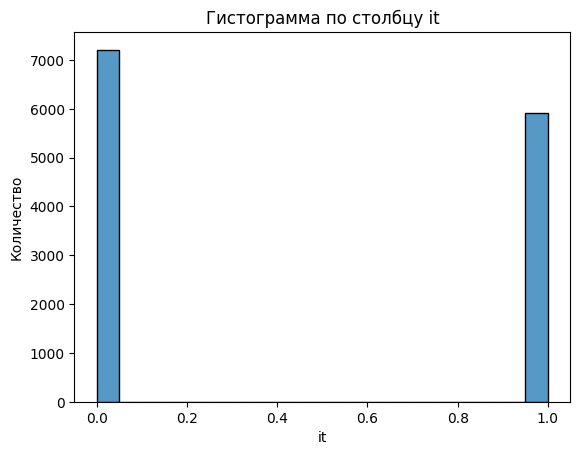

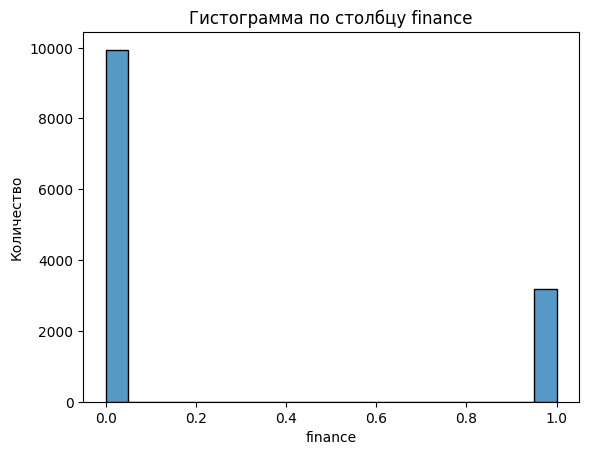

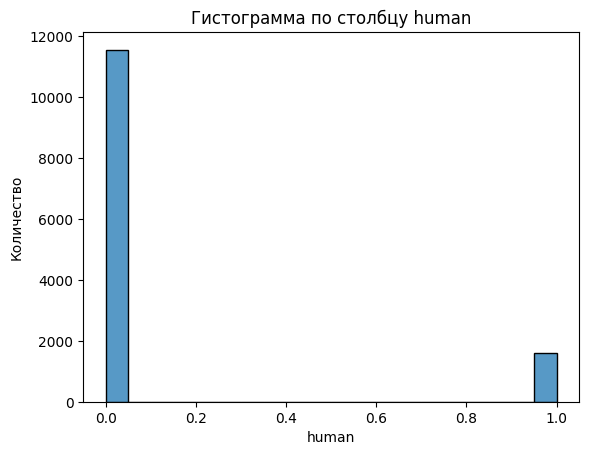

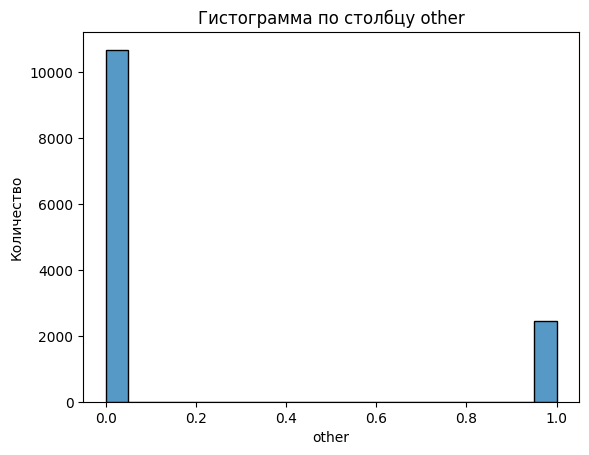

In [ ]:
hist_analysis(data_test, [ 'country_code',
                           'founded_at',
                           'first_funding_at',
                           'last_funding_at',
                           'manufacturing',
                           'biotech',
                           'medicine',
                           'it',
                           'finance',
                           'human',
                           'other'])

Характер гистограмм близок к гистограммам тренеровочной таблицы.

### Построение матриц корреляции

Для оценки корреляции параметров между собой применим матрицу корреляции.

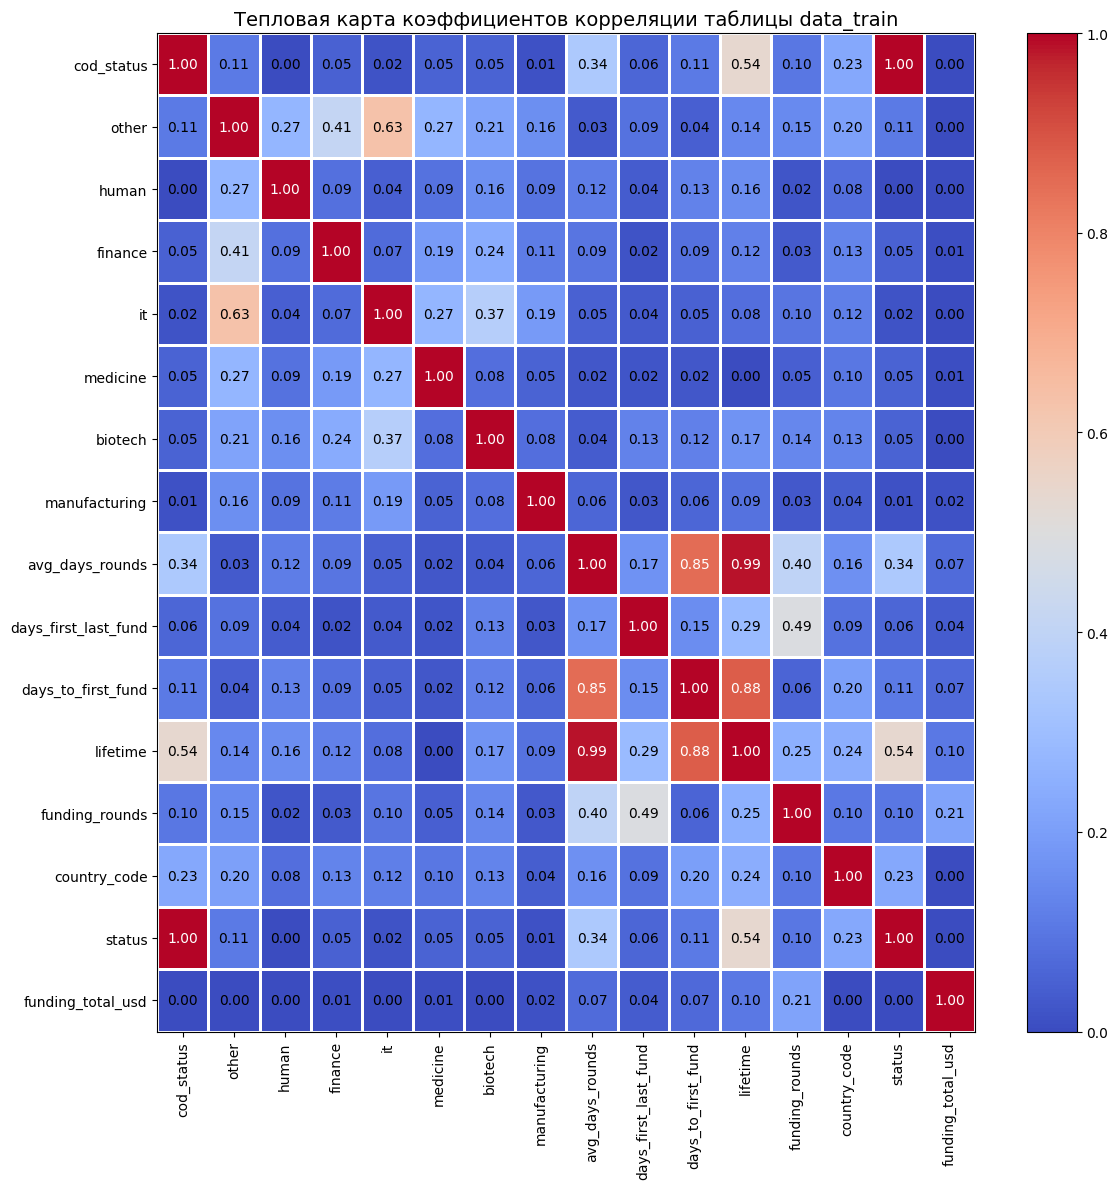

In [ ]:
phik_overview = data_train.drop(['name',
                                 'category_list',
                                 'state_code',
                                 'region',
                                 'city',
                                 'founded_at',
                                'first_funding_at',
                                'last_funding_at',
                                'closed_at'
                                ], axis=1).phik_matrix(interval_cols=['funding_total_usd',
                                                                          'funding_rounds',
                                                                          'lifetime',
                                                                          'days_to_first_fund',
                                                                          'days_first_last_fund',
                                                                          'avg_days_rounds'
                                                                            ])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы data_train",
                        fontsize_factor=1,
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

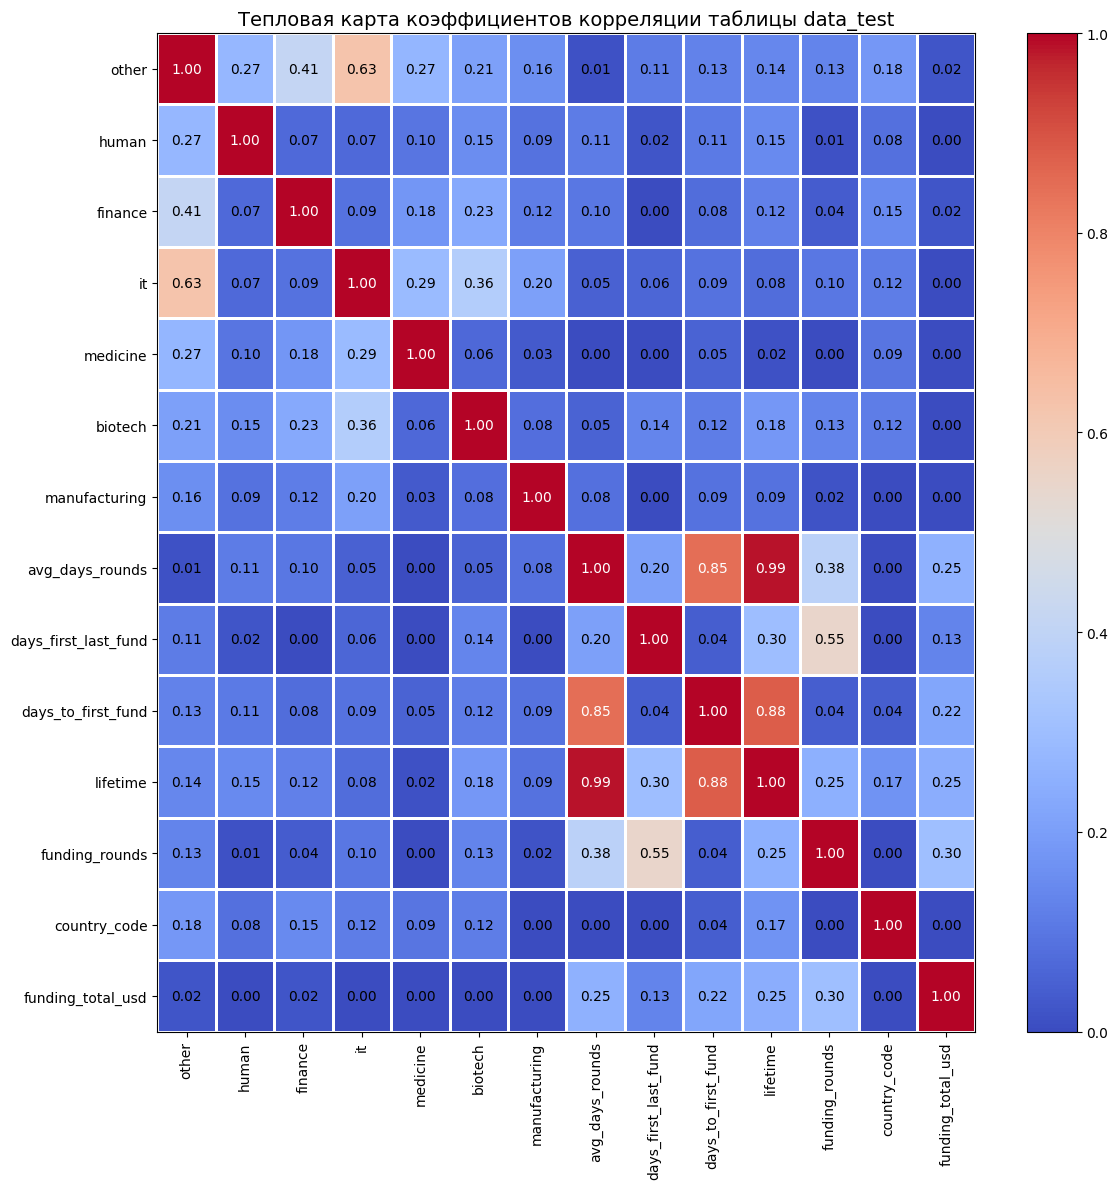

In [ ]:
phik_overview = data_test.drop(['name',
                                 'category_list',
                                 'state_code',
                                 'region',
                                 'city',
                                 'founded_at',
                                'first_funding_at',
                                'last_funding_at',
                                'current_time'
                                ], axis=1).phik_matrix(interval_cols=['funding_total_usd',
                                                                          'funding_rounds',
                                                                          'lifetime',
                                                                          'days_to_first_fund',
                                                                          'days_first_last_fund',
                                                                          'avg_days_rounds'
                                                                            ])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы data_test",
                        fontsize_factor=1,
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

## Подготовка модели

Создадим столбцы для модели:

In [ ]:
train_col = ['funding_total_usd',
             'funding_rounds',
             'days_first_last_fund',
             'avg_days_rounds',
              'manufacturing',
             'biotech',
             'medicine',
             'it',
             'finance',
             'human',
             'other'
            ]

In [ ]:
%%time

RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data_train[train_col],
    data_train['cod_status'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = data_train['cod_status'])

X_train.shape, X_test.shape

# сформируем списки с названиями признаков
ohe_columns = [
              'manufacturing',
              'biotech',
              'medicine',
              'it',
              'finance',
              'human',
               'other'
            ]
num_columns = ['funding_total_usd',
               'funding_rounds',
             'days_first_last_fund',
             'avg_days_rounds'
              ]

# сформируем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='error', sparse=False))
    ]
    )


# сформируем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# сформируем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

     #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'models__penalty' : ['l2'],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', randomized_search.best_score_)


# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
preds = randomized_search.predict(X_test)

print(f'Метрика f1 на тестовой выборке: {f1_score(y_test, preds)}')


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse=False))]),
                                                  ['manufacturing', 'biotech',
                                                   'medicine', 'it', 'finance',
                                                   'human', 'other']),
                                                 ('num', MinMaxScaler(),
                                              

Наилучшая модель - KNeighborsClassifier при параметр n_neighbors=3. Выделим её из pipeline и спрогнозируем значения на тестовых данных.

In [ ]:
model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

## Получение прогноза на тестовых данных

Выпишем столбцы из тестового датафреймы, на основе которых будем делать прогноз.

In [ ]:
test_col = ['funding_total_usd',
             'funding_rounds',
            'days_first_last_fund',
            'avg_days_rounds',
             'manufacturing',
             'biotech',
             'medicine',
             'it',
             'finance',
             'human',
             'other'
            ]

Получим прогноз на тестовых данных.

In [ ]:
X_data_test = data_test[test_col]
X_data_test_preprocessed = preprocessor.transform(X_data_test)
predict_status = model.predict(X_data_test_preprocessed)

Соберём в датафрейм, декодируем признаки и совместим с названиями компаний.

In [ ]:
predict_status = pd.DataFrame(predict_status)
predict_status = predict_status.rename(columns={0:'status_code'})
startups_submit = pd.DataFrame(data_test['name'])
startups_submit = startups_submit.join(predict_status)
startups_submit['status'] = startups_submit.apply(word_status, axis=1)
startups_submit = startups_submit.loc[:, ['name', 'status']]

Проверим собранный датасет:

In [ ]:
startups_submit['status'].value_counts()

status
operating    12210
closed         915
Name: count, dtype: int64

Сохраним его в файл для отправки.

In [ ]:
startups_submit.to_numpy()

array([['Crystalsol', 'operating'],
       ['JBI Fish & Wings', 'operating'],
       ['COINPLUS', 'operating'],
       ...,
       ['Inkd.com', 'operating'],
       ['AdWill', 'operating'],
       ['RingCentral', 'operating']], dtype=object)

In [ ]:
name_array = startups_submit['name'].to_numpy()
status_array = startups_submit['status'].to_numpy()

In [ ]:
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([name_array, status_array]),
    fmt=['%s', '%s'],
    delimiter='|',
    header='name|status',
    comments='',
)

!head submission.csv

name|status
Crystalsol|operating
JBI Fish & Wings|operating
COINPLUS|operating
Imagine Communications|operating
DNA13|operating
Quickfire Games|operating
Sente Inc.|operating
Triosyn|operating
Urgent.ly|operating


Файл создан.

## Анализ работы модели

Проанализируем модель методом shap.

  0%|          | 0/13125 [00:00<?, ?it/s]

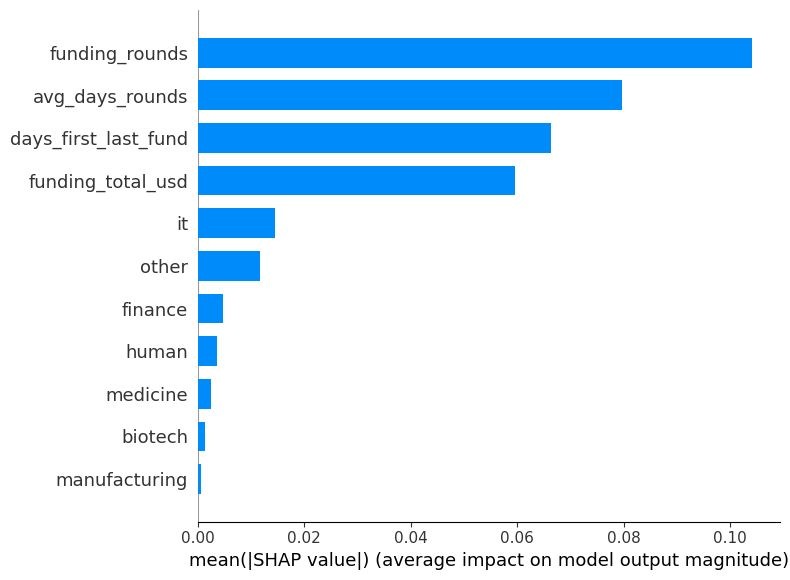

In [ ]:
shap_sample = shap.sample(X_data_test_preprocessed, 1)
explainer = shap.KernelExplainer(model.predict, shap_sample)
shap_values = explainer(X_data_test_preprocessed)
shap.summary_plot(shap_values, X_data_test_preprocessed, plot_type="bar", feature_names=['manufacturing',
                                                                                         'biotech',
                                                                                         'medicine',
                                                                                         'it',
                                                                                         'finance',
                                                                                         'human',
                                                                                         'other',
                                                                                         'funding_total_usd',
                                                                                         'funding_rounds',
                                                                                         'days_first_last_fund',
                                                                                         'avg_days_rounds'])

Как видно из диаграммы наибольший вклад в решение модели вносит количество раундов финансирования.

## Выводы

В рамках работы выполнено следующее:
1. Заполнены пропуски в данных.
2. Рассчитаны новые признаки.
3. Обучена модель и получено предсказания для тестовой выборки. Для лучшей модели на тренеровочном набор f1-мера составила 0,96. В тестовом датасете для 915 компаний прогнозируется закрытие.
4. Установлено, что наибольший вклад в модель вносит признак с количеством раундов финансирования.